In [57]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [58]:
def ler_video(video_path):
    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        print("Erro ao abrir o vídeo.")
        return None
    return cap

In [59]:
def extrator_frames(cap):
    frames_selecionados = []
    # extrair 20 frames igualmente espaçados do vídeo
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, 20, dtype=int)
    for idx in frame_indices:
        cap.set(cv.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frames_selecionados.append(frame)

    return frames_selecionados

analisando frames: [0, 352, 634] de 705 totais


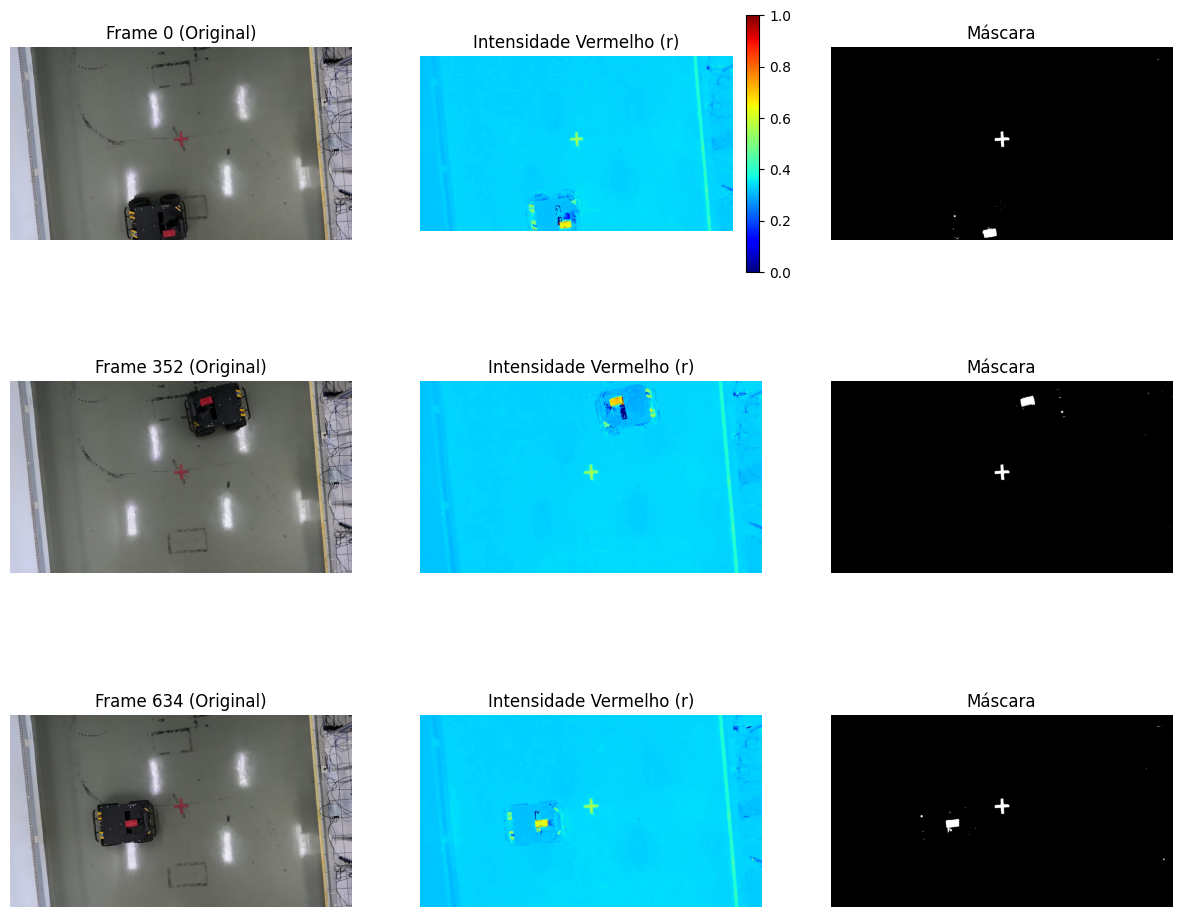

In [60]:
def validar_segmentacao_vermelho(cap):
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) #vê todos os frames pra pegar amostras espalhadas
    
    indices_para_analisar = [0, int(total_frames * 0.5), int(total_frames * 0.9)] #pegando inicio meio e fim
    
    #apenas conguração do plot
    fig, axs = plt.subplots(len(indices_para_analisar), 3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3) # Espaço entre as linhas

    print(f"analisando frames: {indices_para_analisar} de {total_frames} totais")

    for i, idx in enumerate(indices_para_analisar):
        #pula direto para o frame que se quer
        cap.set(cv.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if ret:
            frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB) #converte de BGR para RGB
            img_float = frame_rgb.astype(np.float32) / 255.0
            soma = img_float.sum(axis=2) + 0.00000000000000000000001
            
            r = img_float[:,:,0] / soma
            g = img_float[:,:,1] / soma
            
            #definindo os limiares
            mask = (r > 0.4) & (g < 0.3)
            mask_vis = mask.astype(np.uint8) * 255

            #configuracao da coluna 1 frame original
            axs[i, 0].imshow(frame_rgb)
            axs[i, 0].set_title(f"Frame {idx} (Original)")
            axs[i, 0].axis('off')
            
            #configuracao da coluna 2 mapa de calor para o vermelho
            im = axs[i, 1].imshow(r, cmap='jet', vmin=0, vmax=1)
            axs[i, 1].set_title("Intensidade Vermelho (r)")
            axs[i, 1].axis('off')
            # Adiciona barra de cor apenas na primeira linha para não poluir
            if i == 0: fig.colorbar(im, ax=axs[i, 1], fraction=0.046, pad=0.04)

            #configuracao da coluna 3 máscara binária
            axs[i, 2].imshow(mask_vis, cmap='gray')
            axs[i, 2].set_title("Máscara")
            axs[i, 2].axis('off')
        else:
            print(f"erro ao ler frame {idx}")

    cap.release()
    plt.show()

nome_video = 'video1.mp4'  
cap = cv.VideoCapture(nome_video)
validar_segmentacao_vermelho(cap)

In [61]:
def pixel_para_mundo(u, v): #recebo as coordenadas em pixel e devolvo para milimetros
    #colocando a matriz H que está no pdf. Essa matriz leva de mundo para imagem
    H_pdf = np.array([ 
        [0.9236, 0, 1077.2023],
        [0, -0.9102, 1952.5904],
        [0, 0, 1]
    ])
    
    #precisamos pegar o contrário da informação da matriz H, ou seja, precisamos fazer imagem -> mundo. (u,v) -> (X,Y)
    H_inv = np.linalg.inv(H_pdf) #calculo a inversa da matriz H
    
    ponto_img = np.array([u, v, 1]).reshape(3, 1)   #crio o vetor do ponto na imagem [u, v, 1], o reshape é para garantir que o vetor seja uma matriz coluna
                                                    #util e considerabevl ja que a matriz é 3x3
    # Aplica a transformação: P_mundo = H_inv * P_img
    ponto_mundo = np.dot(H_inv, ponto_img)#multiplico a matriz inversa pela matriz coluna do ponto na imagem
    
    if ponto_mundo[2] != 0: #normalização para o ultimo elemento ser 1
        X = ponto_mundo[0]/ponto_mundo[2]
        Y = ponto_mundo[1]/ponto_mundo[2]
        return float(X), float(Y)
    #return 0.0, 0.0

#resumo:
#1 - pego o pixel u,v
#2 - crio a matriz coluna [u,v,1]
#3 - multiplico pela matriz inversa H_inv
#4 - normalizo dividindo por ponto_mundo[2] que é W em [X,Y,W]

In [ ]:
def processar_frame(frame): #ESTUDOS DIRIGIDOS 8 E 9
    #Cromaticidade
    img_float = frame.astype(np.float32) / 255.0 #convertendo a imagem para float
    soma = img_float.sum(axis=2) + 0.00000000000000001 # Soma dos canais (+ pouquinho para não dividir por 0)
    
    r = img_float[:,:,2] / soma #normalizo o canal vermelho
    g = img_float[:,:,1] / soma #normalizo o canal verde

    mask = ((r > 0.4) & (g < 0.3)).astype(np.uint8) * 255 #denifo os limaires, ou seja, tem q ser um valor de vermelho alto e verde baixo
    
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) 
    #mask eh a imagem binaria onde quero achar os contornos que ja foi criada
    #cv.RETR_EXTERNAL pega apenas os contornos externos
    #cv.CHAIN_APPROX_SIMPLE é um metodo de compressão dos contornos
    
    dados = None
    
    if contours:
        c = max(contours, key=cv.contourArea) #procuro na lista de contornos qual tem a maior area, isso filtra os ruidos pequenos
        
        if cv.contourArea(c) > 50: #pego so com mais de 50 pixels de area tambem pra evitar ruidos
            M = cv.moments(c)
            if M['m00'] != 0: #verico por conta da divisao por zero
                u = int(M['m10'] / M['m00'])
                v = int(M['m01'] / M['m00'])
                
                mu20 = M['mu20'] / M['m00']
                mu02 = M['mu02'] / M['m00']
                mu11 = M['mu11'] / M['m00']
                
                theta_rad = 0.5 * np.arctan2(2 * mu11, mu20 - mu02)
                theta_deg = np.degrees(theta_rad)
                
                X, Y = pixel_para_mundo(u, v) 
                
                dados = {'u': u, 'v': v, 'x_real': X, 'y_real': Y, 'theta': theta_deg}
                
                cv.circle(frame, (u, v), 15, (0, 0, 255), -1)
                #cv.circle(img, center, radius, color, thickness)
                
                #desenha o contorno verde para destacar a região do robo
                cv.drawContours(frame, [c], -1, (0, 255, 0), 2)
                
                #plot do matplotlib para verificaçao
                plt.figure(figsize=(8, 6))
                plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
                plt.title(f'Teste: Contorno (Verde) + Centroide (Vermelho)\nPos: ({X:.0f}, {Y:.0f})mm  Ang: {theta_deg:.0f}°')
                plt.axis('off')
                plt.show()
                # -------------------------------

    return dados, frame

In [63]:
def extrator_pose(frames_selecionados):
    # Listas para guardar os dados da trajetória
    traj_X = []      # Posição X no mundo (mm)
    traj_Y = []      # Posição Y no mundo (mm)
    traj_Theta = []  # Ângulo do robô (graus)
    traj_u = []      # Pixel u (para desenho)
    traj_v = []      # Pixel v (para desenho)

    for  frame in frames_selecionados:
        clear_output(wait=True)
        dados, imagem_processada = processar_frame(frame)
        
        if dados is not None:
            traj_X.append(dados['x_real'])
            traj_Y.append(dados['y_real'])
            traj_Theta.append(dados['theta'])
            traj_u.append(dados['u'])
            traj_v.append(dados['v'])
        
        if len(traj_u) > 1:
                # Converte listas de pontos para o formato que o OpenCV gosta
                pts = np.array(list(zip(traj_u, traj_v)), np.int32) # cria uma matriz de pontos
                # Desenha a linha da trajetória (ciano)
                cv.polylines(imagem_processada, [pts], False, (255, 255, 0), 2)
                frame_rgb = cv.cvtColor(imagem_processada, cv.COLOR_BGR2RGB)
            
                plt.figure(figsize=(10, 6))
                plt.imshow(frame_rgb)
                plt.title(f"Rastreamento em Tempo Real ")
                plt.axis('off')
                plt.show()


In [64]:
def teste_processamento(frames_selecionados):
    for i, frame in enumerate(frames_selecionados):
        clear_output(wait=True)
        print(f"Processando frame {i+1}/{len(frames_selecionados)}")
        dados, imagem_processada = processar_frame(frame)
        plt.imshow(cv.cvtColor(imagem_processada, cv.COLOR_BGR2RGB))
        plt.title(f'Frame {i+1} Processado')
        plt.show()

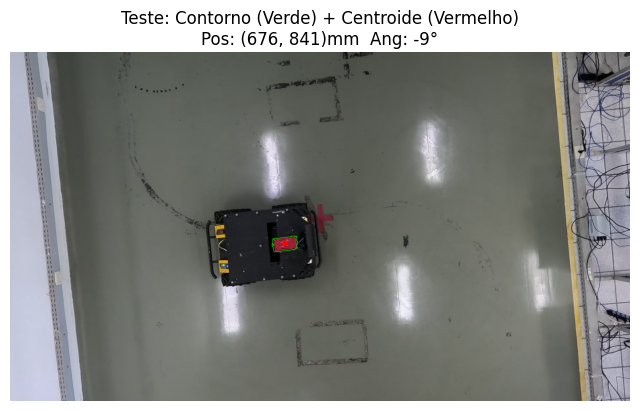

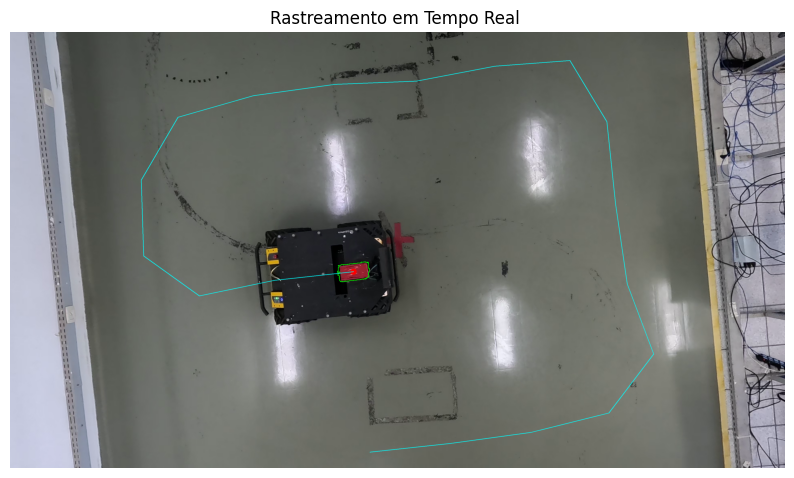

In [65]:
def pipeline():
    cap = ler_video("video1.mp4")
    # validar_segmentacao_vermelho(cap)
    frames_selecionados = extrator_frames(cap)
    # teste_processamento(frames_selecionados)
    extrator_pose(frames_selecionados)  
    
    
pipeline()